# [Advent of Code 2021](https://adventofcode.com/2021)

Partially inspired by [Norvig's pytudes](https://github.com/norvig/pytudes/blob/main/ipynb/Advent-2020.ipynb), although I probably won't be using the same style.

Goals
------
* Try to finish all gold stars on day of puzzle
* Learn new python features
* Investigate github copilot

In [1]:
# Imports

from collections import defaultdict, Counter, deque
import itertools
from functools import lru_cache
import json
import numpy as np
import numpy.typing as npt
import networkx as nx
import re
from typing import Callable, TypeVar, Union, Optional

T = TypeVar('T')

# Helper functions

def data(day: int, parser: Callable[[str], T] = str) -> list[T]:
  with open(f"../data/2021/day{day}.txt") as f:
    return [parser(line.strip()) for line in f.readlines()]

def split_csv_row(row: str) -> list[int]:
  return [int(x) for x in row.split(',')]

def split_int_row(row: str) -> list[int]:
  return [int(x) for x in row]

def bin2int(l: Union[list[int], str]) -> int:
  return int("".join(str(i) for i in l), 2)

def triangular_number(n: int) -> int:
  return n * (n + 1) // 2

## Day 1

Determine number of increments in list

In [13]:
data1 = data(1, int)

In [14]:
def day1(data: list[int]) -> int:
  count, current = 0, data[0]
  for i in data[1:]:
    if i > current:
      count += 1
    current = i
  return count

day1(data1)

1688

In [48]:
def win3(data: list[int]) -> list[int]:
  for i in range(len(data) - 2):
    yield sum(data[i:i+3])

day1(list(win3(data1)))

1728

## Day 2

Maintain sum of depth and length

In [229]:
data2 = data(2)

In [22]:
def day2(data: list[str]) -> int:
  depth, length = 0, 0
  for i in data:
    mode, amount = i.split(' ')
    amount = int(amount)
    match mode:
      case 'forward':
        length += amount
      case 'down':
        depth += amount
      case 'up':
        depth -= amount
  return depth * length

day2(data2)

1451208

In [26]:
def day2_2(data: list[str]) -> int:
  depth, length, aim = 0, 0, 0
  for i in data:
    mode, amount = i.split(' ')
    amount = int(amount)
    match mode:
      case 'forward':
        length += amount
        depth += amount * aim
      case 'down':
        aim += amount
      case 'up':
        aim -= amount
  return depth * length

day2_2(data2)

1620141160

## Day 3

Can probably be solved with bit tricks, but I'll just implement them as array problems.

In [222]:
data3 = data(3)

In [177]:
def day3(data: list[int]):
  total = len(data)
  size = len(data[0])
  sums = [0] * size
  for binary in data:
    for i, v in enumerate(binary):
      sums[i] += int(v)
  
  gamma = [0 if total - i > i else 1 for i in sums]
  epsilon = [i ^ 1 for i in gamma]
  return bin2int(gamma) * bin2int(epsilon)

day3(data3)

2954600

In [179]:
def find_boundary(data: list[str], start: int, end: int, index: int) -> int:
  # TODO: this can be implemented as binary search
  for i, v in enumerate(data[start:end+1]):
    if v[index] == '1':
      return start + i
  return start

def scrubber(data: list[str], lcd: bool) -> int:
  # Run "binary search"
  low, high = 0, len(data) - 1
  for target in range(len(data[0])):
    index = low + ((high - low + 1) // 2)
    item = data[index][target]

    if lcd and item == '0':
      # Select all '1's in the bottom half
      low = find_boundary(data, index, high, target)
    elif lcd and item == '1':
      # Select all '0's in the top half
      high = find_boundary(data, low, index, target) - 1
    elif item == '0':
      # Select all '0's from the top through to the bottom half
      high = find_boundary(data, index, high, target) - 1
    else:
      # Select all '1' starting from the top half to the end
      low = find_boundary(data, low, index, target)
    
    if low == high:
      break

  return data[low]

def day3_2(data: list[str]) -> int:
  data = sorted(data)
  oxygen = scrubber(data, False)
  c02 = scrubber(data, True)
  return bin2int(oxygen) * bin2int(c02)

day3_2(data3)

1662846

## Day 4
Reference storing Bingo Boards

In [99]:
data4 = data(4)

class BingoBoard:
  def __init__(self):
    self.board = []
    self.size = 0
    # TODO: this state should be stored elsewhere
    self.rows = []
    self.cols = []
    
  def add_row(self, row: list[int]):
    self.board.append(row)
    if not self.size:
      self.size = len(row)
      self.rows = [0] * self.size
      # Assume column size is same as row size
      self.cols = [0] * self.size

def parse_data4(data: list[str]) -> tuple[list[int], list[BingoBoard]]:
  numbers = [int(x) for x in data[0].split(',')]
  boards, board = [], None
  for row in data[1:]:
    if row == '':
      board = BingoBoard()
      boards.append(board)
    else:
      board.add_row([int(x) for x in re.split('\s+', row)])
  return numbers, boards

def analyze_boards(boards: list[BingoBoard]) -> dict[list[tuple[int,int,BingoBoard]]]:
  # For each number, store the row and column with every board it was found in
  keys = defaultdict(lambda: [])
  for board in boards:
    for i, row in enumerate(board.board):
      for j, v in enumerate(row):
        keys[v].append((i, j, board))
  return keys

In [75]:
def calculate_score(board: BingoBoard, numbers: set[int]) -> int:
  score = 0
  for row in board.board:
    for v in row:
      if v not in numbers:
        score += v
  return score

def day4(data: list[str]) -> int:
  numbers, boards = parse_data4(data)  
  keys = analyze_boards(boards)
  selected = set()
  for number in numbers:
    if number in selected:
      continue
    selected.add(number)
    for i, j, board in keys[number]:
      board.rows[i] += 1
      board.cols[j] += 1
      if board.size == board.rows[i] or board.size == board.cols[j]:
        return calculate_score(board, selected) * number

day4(data4)

4512

In [82]:
def retroactive_selected(inputs: list[int], end: int) -> int:
  index = inputs.index(end) + 1
  return set(inputs[:index])

def day4_2(data: list[str]) -> int:
  numbers, boards = parse_data4(data)  
  keys = analyze_boards(boards)
  selected = set()
  completed, last_winner, last_num = set(), None, 0
  for number in numbers:
    if number in selected:
      continue
    selected.add(number)
    for i, j, board in keys[number]:
      if board in completed:
        continue
      board.rows[i] += 1
      board.cols[j] += 1
      if board.size == board.rows[i] or board.size == board.cols[j]:
        completed.add(board)
        last_winner, last_num = board, number
  return calculate_score(last_winner, retroactive_selected(numbers, last_num)) * last_num

day4_2(data4)

5586

## Day 5

Some possible ideas for solutions: 
1. use vector products between each pair (n^2) and remove duplicates somehow
2. use a 2-d interval tree and detect where sums on a point are greater than 1
3. fill a 2-d grid and iterate through points

Implementing with idea 3 for now, since size of grid is small relative to number of lines

In [223]:
Line = tuple[tuple[int, int], tuple[int, int]]

def parse5(line: str) -> list[Line]:
  result = re.split('[\s,]', line)
  return (
    (int(result[0]), int(result[3])), # xs
    (int(result[1]), int(result[4])) # ys
  )

data5 = data(5, parse5)

In [103]:
class BaseHydroVents:
  def __init__(self, size: int) -> None:
    self.grid = np.zeros([size, size])

  def add_line(self, line: Line) -> None:
    if line[0][0] == line[0][1]:
      self.add_vertical_line(sorted(line[1]), line[0][0])
    elif line[1][0] == line[1][1]:
      self.add_horizontal_line(sorted(line[0]), line[1][0])
    else:
      self.add_diagonal_line(line)

  def add_diagonal_line(self, line: Line) -> None:
    # Stub
    return

  def add_horizontal_line(self, xs: tuple[int, int], y: int) -> None:
    for x in range(xs[0], xs[1] + 1):
      self.grid[y][x] += 1

  def add_vertical_line(self, ys: tuple[int, int], x: int) -> None:
    for y in range(ys[0], ys[1] + 1):
      self.grid[y][x] += 1

def max_vent_point(data: list[Line]) -> int:
  return max([max(max(x[0]), max(x[1])) for x in data])

def day5(data: list[Line]) -> int:
  size = max_vent_point(data) + 1
  vents = BaseHydroVents(size)
  for line in data:
    vents.add_line(line)
  mask = vents.grid > 1
  return np.count_nonzero(mask)

day5(data5)


4728

In [104]:
class HydroVents (BaseHydroVents):
  def __init__(self, size: int) -> None:
    self.grid = np.zeros([size, size])

  def add_diagonal_line(self, line: Line) -> None:
    # Only supports 45 degree lines
    xs, ys = line[0], line[1]
    dx = 1 if xs[1] > xs[0] else -1
    dy = 1 if ys[1] > ys[0] else -1
    length = abs(xs[1] - xs[0]) + 1
    for i in range(length):
      self.grid[ys[0] + dy * i][xs[0] + dx * i] += 1

def day5_2(data: list[Line]) -> int:
  size = max_vent_point(data) + 1
  vents = HydroVents(size)
  for line in data:
    vents.add_line(line)
  mask = vents.grid > 1
  return np.count_nonzero(mask)

day5_2(data5)


17717

## Day 6

Seems like a DP problem

In [226]:
data6 = data(6, split_csv_row)

In [99]:
@lru_cache(None)
def spawns6(days: int):
  if days < 6:
    return 1
  return spawns6(days-7) + spawns8(days-7)

@lru_cache(None)
def spawns8(days: int):
  if days < 8:
    return 1
  return spawns6(days-9) + spawns8(days-9)

def day6(data: list[int], days: int) -> int:
  result = [spawns6(days + 6 - i) for i in data]
  return sum(result)

day6(data6, 79)

394994

In [100]:
day6(data6, 255)

1765974267455

## Day 7

Minimize v-shaped curve $ |F(c)| $ where $ A - c = F $

In [34]:
data7 = data(7, split_csv_row)[0]

In [38]:
CostFunction7 = Callable[[npt.ArrayLike], int]
def fuel_used(input: npt.ArrayLike) -> int:
  return np.sum(np.abs(input))

def deltas(input: npt.ArrayLike, current: int, cost: CostFunction7) -> tuple[int, int, int]:
  y = cost(input - current)
  left = cost(input - current - 1)
  right = cost(input - current + 1)
  return left, y, right

# TODO: could use scipy.optimize.minimize instead
def bsearch7(input: npt.ArrayLike, low: int, high: int, cost: CostFunction7) -> int:
  while low < high:
    mid = (low + high) // 2
    left, y, right = deltas(input, mid, cost)
    if left < y:
      low = mid + 1
    elif right < y:
      high = mid
    else:
      low, high = mid, mid
  return mid

def day7(data: list[int], cost: CostFunction7) -> int:
  input = np.array(data)
  hmin, hmax = np.min(input), np.max(input)
  result = bsearch7(input, hmin, hmax, cost)
  return cost(input - result)

day7(data7, fuel_used)

343605

In [3]:
def fuel_used2(input: npt.ArrayLike) -> int:
  return np.sum(triangular_number(np.abs(input)))

day7(data7, fuel_used2)

NameError: name 'day7' is not defined

## Day 8

Set intersections

In [224]:
data8 = data(8)

In [101]:
Knowns9 = dict[int, set[str]]

items_by_length = defaultdict(lambda: None, {
  2: 1,
  3: 7,
  4: 4,
  7: 8
})
def disambiguate6(item: set[str], knowns: Knowns9) -> int:
    if knowns[1] - item:
      return 6
    elif not knowns[4] - item:
      return 9
    else:
      return 0
def disambiguate5(item: set[str], knowns: Knowns9) -> int:
    if not knowns[7] - item:
      return 3
    elif len(knowns[6] - item) == 1:
      return 5
    else:
      return 2

def group_items(data: list[str]) -> tuple[Knowns9]:
  knowns = {}
  unknowns = []
  for i in data:
    item = set(i)
    match len(item):
      case 6:
        unknowns.append(item)
      case _:
        knowns[items_by_length[len(item)]] = item
  for item in unknowns:
    knowns[disambiguate6(item, knowns)] = item
  # Disambiguate5 not required to be run, we can do that while decoding the output
  return knowns

def parse_line(line: str) -> str:
  input, output = tuple(group.split(' ') for group in line.split(' | '))
  knowns = group_items(input)
  for i in output:
    item = set(i)
    match len(item):
      case 5:
        yield disambiguate5(item, knowns)
      case 6:
        yield disambiguate6(item, knowns)
      case _:
        yield items_by_length[len(item)]

# Overly complicated way to do what's required, but it's pretty clear what's coming in part 2
def day8(data: list[str]) -> int:
  count = 0
  targets = items_by_length.values()
  for line in data:
    result = parse_line(line)
    for number in result:
      if number in targets:
        count += 1
  return count

day8(data8)

383

In [93]:
def day8_2(data: list[str]) -> int:
  total = 0
  for line in data:
    result = parse_line(line)
    total += int(''.join(str(i) for i in result))
  return total

day8_2(data8)

998900

## Day 9
* Part 1: numpy array masking
* Part 2: Recursive search from results of part 1

In [228]:
data9 = np.array(data(9, split_int_row))

In [53]:
def get_basins(data: npt.ArrayLike) -> npt.ArrayLike:
  zero_row, zero_col = np.full((1, data.shape[1]), 10), np.full((data.shape[0], 1), 10)
  a = np.concatenate((data[1:], zero_row))
  b = np.concatenate((zero_row, data[:-1]))
  c = np.concatenate((data[:, 1:], zero_col), axis=1)
  d = np.concatenate((zero_col, data[:, :-1]), axis=1)

  mask = (data - a < 0) & (data - b < 0) & (data - c < 0) & (data - d < 0)
  indices = np.where(mask)
  return [(index[1], index[0]) for index in zip(indices[0], indices[1])]

def day9(data: npt.ArrayLike) -> int:
  basins = get_basins(data)
  return sum([data[y][x] for x, y in basins]) + len(basins)

day9(data9)

508

In [61]:
def day9_2(data: npt.ArrayLike) -> int:
  claimed = set()
  size = data9.shape

  def claim(x: int, y: int) -> int:
    if x < 0 or y < 0 or x >= size[1] or y >= size[0]:
      return 0
    if (x, y) in claimed:
      return 0
    if data[y][x] == 9:
      return 0
    claimed.add((x, y))
    return 1 + claim(x+1, y) + claim(x-1, y) + claim(x, y+1) + claim(x, y - 1)

  basins = [] # TODO: use 3-heap instead
  for (x, y) in get_basins(data):
    if basin_size := claim(x, y):
      basins.append(basin_size)
  return np.prod(sorted(basins, reverse=True)[:3])

day9_2(data9)

1564640

## Day 10
Stack stuff

In [225]:
data10 = data(10)

In [8]:
opens = {
  '(': ')',
  '[': ']',
  '{': '}',
  '<': '>',
}
error_scores = {
  ')': 3,
  ']': 57,
  '}': 1197,
  '>': 25137,
}

def handle_line10(line: str) -> str:
  stack = []
  for i in line:
    if i in opens:
      stack.append(i)
    elif opens[stack[-1]] == i:
      stack.pop()
    else:
      return i
  return stack

def day10(data: list[str]) -> int:
  lines = ([handle_line10(line) for line in data])
  errors = Counter([line for line in lines if type(line) is str])
  return sum(error_scores[i] * errors[i] for i in errors)

day10(data10)


319233

In [9]:
closing_scores = {
  ')': 1,
  ']': 2,
  '}': 3,
  '>': 4,
}

def closing_score(close: list[str]) -> int:
  score = 0
  for i in reversed(close):
    score = score * 5 + closing_scores[opens[i]]
  return score

def day10_2(data: list[str]) -> int:
  lines = ([handle_line10(line) for line in data])
  scores = [closing_score(line) for line in lines if type(line) is list]
  mid = len(scores) // 2
  return sorted(scores)[mid]

day10_2(data10)

1118976874

## Day 11
Array operations

In [227]:
data11 = np.array(data(11, split_int_row))

In [214]:
def run_flashes(data: npt.ArrayLike, flashed: set[int], size: tuple[int, int], debug = False) -> bool:
  changed = False
  for i in reversed(np.argsort(data.flatten())):
    x, y = i % size[1], i // size[1]
    if data[y][x] > 9 and i not in flashed:
      for index in itertools.product([x-1, x, x+1], [y-1, y, y+1]):
        if index[0] == x and index[1] == y:
          continue
        if index[0] < 0 or index[0] >= size[1]:
          continue
        if index[1] < 0 or index[1] >= size[0]:
          continue
        data[index[1]][index[0]] += 1
      flashed.add(i)
      changed = True
  return changed

def check_flashes(data: npt.ArrayLike, size: tuple[int, int], debug = False) -> set[int]:
  flashed = set()
  changed = True
  data += 1
  while changed:
    changed = run_flashes(data, flashed, size, debug)
  np.put(data, list(flashed), [0])
  return flashed

def day11(data: npt.ArrayLike) -> int:
  flashes = 0
  size = data.shape
  current = data.copy()
  for _ in range(100):
    flashes += len(check_flashes(current, size))
  return flashes

day11(data11)  

1719

In [215]:
def day11_2(data: npt.ArrayLike) -> int:
  size = data.shape
  current = data.copy()
  for i in range(10000):
    check_flashes(current, size)
    if np.sum(current) == 0:
      return i + 1
  raise Exception('Too few iterations')

day11_2(data11)

232

## Day 12

Some graph stuff

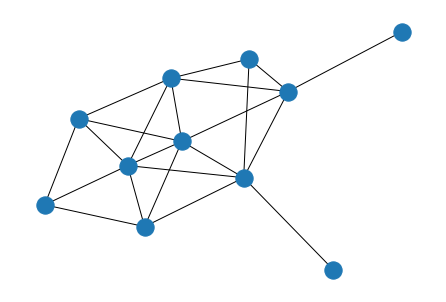

In [33]:
data12 = nx.Graph()

def add_edge(line: str):
  a, b = line.split('-')
  data12.add_edge(a, b)
_ = data(12, add_edge)

nx.draw(data12)

In [34]:
def day12(G: nx.Graph) -> int:
  visited = set()
  
  def backtrack(node: str):
    if node == 'start':
      return 1
    if node in visited:
      return 0
    if node[0].islower():
      visited.add(node)
    score = 0
    for neighbor in G[node]:
      score += backtrack(neighbor)
    if node[0].islower():
      visited.remove(node)
    return score
  return backtrack('end')

day12(data12)

5252

In [35]:
def day12_2(G: nx.Graph) -> int:
  visited = Counter()
  
  def backtrack(node: str, duplicate = None):
    if node == 'start':
      return 1
    if visited[node] > 0:
      if node == 'end' or duplicate:
        return 0
      duplicate = node
    if node[0].islower():
        visited[node] += 1
    score = 0
    for neighbor in G[node]:
      score += backtrack(neighbor, duplicate)
    if node[0].islower():
      visited[node] -= 1
    return score
  return backtrack('end')

day12_2(data12)

147784

## Day 13

Array operations

In [36]:
data13 = data(13)

def format_data13(data: list[str]) -> tuple[tuple[int, int], tuple[str, int]]:
  entries, folds = [], []
  x_max, y_max = 0, 0
  for entry in data:
    if ',' in entry:
      x, y = split_csv_row(entry)
      x_max, y_max = max(x, x_max), max(y, y_max)
      entries.append((x, y))
    elif 'fold' in entry:
      direction, position = entry.split('=')
      folds.append((0 if direction[-1] == 'y' else 1, int(position)))

  result = np.zeros((y_max + 1, x_max + 1), dtype=int)
  for entry in entries:
    result[entry[1], entry[0]] = 1
  return result, folds

In [38]:
# These folds only work if the fold splits the array in half
def fold_y(data: npt.ArrayLike, y: int) -> int:
  a, b = data[:y], np.flip(data[y+1:], 0)
  return a+b
def fold_x(data: npt.ArrayLike, x: int) -> int:
  a, b = data[:, :x], np.flip(data[:, x+1:], 1)
  return a+b

def fold(data: npt.ArrayLike, fold: tuple[int, int]) -> npt.ArrayLike:
  return fold_y(data, fold[1]) if fold[0] == 0 else fold_x(data, fold[1])
  
def day13() -> int:
  origami, folds = format_data13(data13)
  for direction in folds:
    origami = fold(origami, direction)
    break
  return np.count_nonzero(origami)

day13()

850

In [39]:
def day13_2() -> int:
  origami, folds = format_data13(data13)
  for direction in folds:
    origami = fold(origami, direction)
  result = np.where(origami > 0, '#', ' ')
  return np.savetxt('output_day13.txt', result, fmt='%s')

day13_2()

## Day 14
Another dp problem

In [26]:
data14 = data(14)

def format14(data: list[str]) -> tuple[str, dict[str, str]]:
  sequence = data[0]
  transitions = {input: output for input, output in (line.split(' -> ') for line in data[2:])}
  return sequence, transitions

In [29]:
def day14(days: int) -> int:
  sequence, transitions = format14(data14) 

  @lru_cache(maxsize=None)
  def transition(input: str, steps: int) -> str:
    output = transitions[input]
    if steps == 0:
      return Counter(f'{input[0]}{output}')
    return transition(f'{input[0]}{output}', steps - 1) + transition(f'{output}{input[1]}', steps - 1)
      
  def run_transition(input: str, steps: int) -> str:
    new = Counter()
    for i in range(1, len(input)):
      new += transition(input[i-1:i+1], steps)
    new[input[-1]] += 1
    return new

  counts = run_transition(sequence, days - 1).most_common()
  return counts[0][1] - counts[-1][1]

day14(10)

2435

In [30]:
day14(40)

2587447599164

## Day 15

Dijkstra

In [106]:
data15 = np.array(data(15, split_int_row))

In [160]:
# TODO: this is pretty slow, some optimization might be called for
def generate_array_graph(data: npt.ArrayLike) -> nx.Graph:
  graph = nx.DiGraph()
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      if i+1 < data.shape[0]:
        graph.add_edge((i, j), (i+1, j), weight=data[i+1, j])
        graph.add_edge((i+1, j), (i, j), weight=data[i, j])
      if j+1 < data.shape[1]:
        graph.add_edge((i, j), (i, j+1), weight=data[i, j+1])
        graph.add_edge((i, j+1), (i, j), weight=data[i, j])
  return graph

def day15(data: npt.ArrayLike) -> int:
  graph = generate_array_graph(data)
  length = nx.algorithms.shortest_paths.weighted.dijkstra_path_length(graph, (0, 0), (data.shape[0]-1, data.shape[1]-1))
  return length

day15(data15)

621

In [161]:
def wrap_general(start: int, end: int, num: int) -> int:
  return start + (num - start) % (end - start)

def wrap(num: int) -> int:
  return wrap_general(1, 10, num)

def expand_array(data: npt.ArrayLike) -> npt.ArrayLike:
  temp = data.copy()
  for i in range(1, 5):
    temp = np.concatenate((temp, wrap(data + i)), axis=1)
  result = temp.copy()
  for i in range(1, 5):
    result = np.concatenate((result, wrap(temp + i)), axis=0)
  return result
  
day15(expand_array(data15))

2904

## Day 16

Compiler/parsing stuff

In [214]:
binary_map = {
  '0': '0000',
  '1': '0001',
  '2': '0010',
  '3': '0011',
  '4': '0100',
  '5': '0101',
  '6': '0110',
  '7': '0111',
  '8': '1000',
  '9': '1001',
  'A': '1010',
  'B': '1011',
  'C': '1100',
  'D': '1101',
  'E': '1110',
  'F': '1111',
}

data16 = ''.join([binary_map[x] for x in data(16)[0]])

In [220]:
def parse_packet(input: str):
  version = parse_version(input[:3])
  packet_type = parse_type(input[3:6])
  output, remainder = parse_body(packet_type, input[6:])
  return version, packet_type, output, remainder

def parse_version(input: str):
  return bin2int(input)

def parse_type(input: str):
  return bin2int(input)

def parse_body(packet_type: int, input: str):
  if packet_type == 4:
    return parse_bits(input)
  return parse_subpacket(input)

def parse_subpacket(input: str):
  length_type = input[0]
  length_size = 16 if length_type == '0' else 12
  length_bits, rest = input[1:length_size], input[length_size:]
  length = parse_length(length_bits)
  if length_size == 12:
    return parse_subpackets_by_count(rest, length)
  return parse_subpackets(rest[:length]), rest[length:]

def parse_subpackets(input: str):
  packets = []
  while '1' in input:
    version, packet_type, output, input = parse_packet(input)
    packets.append((version, packet_type, output))
  return packets

def parse_subpackets_by_count(input: str, count: int):
  packets = []
  while len(packets) < count:
    version, packet_type, output, input = parse_packet(input)
    packets.append((version, packet_type, output))
  return packets, input

def parse_length(input: str):
  return bin2int(input)

def parse_bits(input: str):
  result = ''
  while input:
    current, input = input[:5], input[5:]
    result += current[1:]
    if current[0] == '0':
      break
  return bin2int(result), input

Packet = tuple[int, Union[list["Packet"], int]]

def expand_packet_versions(packet: Packet) -> list[int]:
  version, body = packet[0], packet[2]
  yield version
  if type(body) is not int:
    for subpacket in body:
      version, _, packet = subpacket
      yield from expand_packet_versions(subpacket)

def day16(data: str) -> int:
  packet = parse_packet(data)
  return sum([x for x in expand_packet_versions(packet)])

day16(data16)


957

In [221]:
def evaluate_packet(packet: Packet) -> int:
  packet_type, body = packet[1], packet[2]
  match packet_type:
    case 4:
      return body
    case 0:
      return sum([evaluate_packet(subpacket) for subpacket in body])
    case 1:
      return np.prod([evaluate_packet(subpacket) for subpacket in body])
    case 2:
      return min([evaluate_packet(subpacket) for subpacket in body])
    case 3:
      return max([evaluate_packet(subpacket) for subpacket in body])
    case 5:
      a, b = evaluate_packet(body[0]), evaluate_packet(body[1])
      return 1 if a > b else 0
    case 6:
      a, b = evaluate_packet(body[0]), evaluate_packet(body[1])
      return 1 if a < b else 0
    case 7:
      a, b = evaluate_packet(body[0]), evaluate_packet(body[1])
      return 1 if a == b else 0

def day16_2(data: str) -> int:
  packet = parse_packet(data)
  return evaluate_packet(packet)

day16_2(data16)

744953223228

## Day 17

More triangular numbers and some kinematic equations with a = -1

In [16]:
data17 = data(17)[0]

In [29]:
Position = tuple[int, int]

def format17(data: str) -> tuple[tuple[int, int]]:
  pattern = re.compile('.+x=([0-9\-]+)\.\.([0-9\-]+), y=([0-9\-]+)\.\.([0-9\-]+)')
  x1, x2, y1, y2 = pattern.match(data).groups()
  return (int(x1), int(x2)), (int(y1), int(y2))


def day17(data: str):
  _, y = format17(data)
  # Assume x is always positive and y is always negative
  # Since the upward distance will be totally negated by gravity, what actually matters is the final step, which will be of distance -(y+1)
  # This is equal to triangular_number(abs(y)-1), or equivalently triangular_number(y)
  return triangular_number(y[0])

day17(data17)


10296

In [31]:
def day17_2(data: str):
  x, y = format17(data)

  # Max x velocity is a single step shot to the end of the x-grid
  vx_min, vx_max = 0, x[1]
  # Min x velocity will be totally exhausted upon reaching the start of the x-grid
  while triangular_number(vx_min) < x[0]:
    vx_min += 1

  # Min y velocity is a single step shot to the bottom of the y-grid (negative)
  # Max y velocity is the result of part 1
  vy_min, vy_max = y[0], abs(y[0]) - 1

  def check_shot(vx: int, vy: int):
    # Steps should be at least 1 when shooting downwards
    # When shooting upwards, there will be y upward steps, 1 hanging step, y downward steps, and then at least one -(y+1) or greater step
    steps = 1 if vy <= 0 else vy * 2 + 2
    while True:
      dx = (triangular_number(vx) - triangular_number(vx - steps)) if vx > steps else triangular_number(vx)
      dy = triangular_number(vy) - triangular_number(vy - steps)
      if dx > x[1] or dy < y[0]:
        return False
      if dx >= x[0] and dx <= x[1] and dy >= y[0] and dy <= y[1]:
        return True
      steps += 1

  results = []
  for vx in range(vx_min, vx_max + 1):
    for vy in range(vy_min, vy_max + 1):
      if check_shot(vx, vy):
        results.append((vx, vy))

  return len(results)

day17_2(data17)

2371

## Day 18

Unbalanced binary tree, hopping across leaves

In [4]:
TreeList = tuple[Union[int, 'TreeList'], Union[int, 'TreeList']]
data18 = data(18, json.loads)

In [7]:
class BaseNode:
  def __init__(self, parent: Optional["Node"] = None, is_left: Optional[bool] = True):
    self.is_left = is_left
    self.parent = parent

class Leaf(BaseNode):
  def __init__(self, value: int, parent: Optional["Node"] = None, is_left: Optional[bool] = True):
    super().__init__(parent, is_left)
    self.value = value

class Node(BaseNode):
  def __init__(self, left: Union[Leaf, 'Node'], right: Union[Leaf, 'Node'], parent: Optional["Node"] = None, is_left: Optional[bool] = True):
    super().__init__(parent, is_left)
    self.left = left
    left.is_left = True
    self.right = right
    right.is_left = False

def make_leaf(node: Union[TreeList, int]):
  if type(node) is int:
    return Leaf(node)
  return make_node(node)

def make_node(data: TreeList, parent: Optional["Node"] = None, is_left: Optional[bool] = True):
  left, right = make_leaf(data[0]), make_leaf(data[1])
  node = Node(left, right, parent, is_left)
  left.parent, right.parent = node, node
  return node

def inorder(node: BaseNode):
  if type(node) is Leaf:
    yield node
  else:
    yield from inorder(node.left)
    yield from inorder(node.right)

def dfs(root: 'Tree'):
  queue = deque([(root, 0)])
  results = deque()
  while queue:
    node, depth = queue.popleft()
    if type(node) is Leaf:
      # TODO: figure how to get the desired output earlier
      results.appendleft((node, depth))
    else:
      queue.append((node.right, depth+1))
      queue.append((node.left, depth+1))
  return results

class Tree:
  def __init__(self, data: list[int]):
    self.root = make_node(data)

  def add(self, data: list[int]):
    node = make_node(data)
    root = self.root
    self.root = Node(root, node)
    root.parent = self.root
    node.parent = self.root
    self.reduce()

  def switch(self, node: BaseNode):
    if node.is_left:
      node.parent.left = node
    else:
      node.parent.right = node

  def reduce(self):
    changed = True
    while changed:
      changed = self.reduce_once()

  def reduce_once(self):
    # TODO: figure out ahead of time what the max depth size is
    if self.explode():
      return True
    if self.split():
      return True
    return False

  def explode(self):
    leaves = list(inorder(self.root))
    indices = {leaf: i for i, leaf in enumerate(inorder(self.root))}
    for leaf, depth in dfs(self.root):
      if depth <= 4:
        continue
      # Explode
      index = indices[leaf]
      # Note: due to order of dfs, the left child is always the first one
      if index > 0:
        leaves[index-1].value += leaf.value
      # Note: if a node explodes, both its children are leaves
      right = leaves[index+1]
      if len(leaves) > index+2:
        leaves[index+2].value += right.value
      leaf.value, right.value = 0, 0
      self.switch(Leaf(0, leaf.parent.parent, leaf.parent.is_left))
      return True

  def split(self):
    for leaf in inorder(self.root):
      if leaf.value < 10:
        continue
      # Split
      left, right = leaf.value // 2, int(np.ceil(leaf.value/2))
      node = make_node([left, right], leaf.parent, leaf.is_left)
      self.switch(node)
      return True

def magnitude(node: Node) -> int:
  left, right = node.left, node.right
  left = magnitude(node.left) if type(node.left) is not Leaf else node.left.value
  right = magnitude(node.right) if type(node.right) is not Leaf else node.right.value
  return 3 * left + 2 * right

def day18(data: list[TreeList]):
  result = Tree(data[0])
  for item in data[1:]:
    result.add(item)
  return magnitude(result.root)

day18(data18)

4202

In [100]:
def get_combo(x: TreeList, y: TreeList):
  result = Tree(x)
  result.add(y)
  return magnitude(result.root)

def get_combo_size(x: TreeList, y: TreeList):
  return max(get_combo(x, y), get_combo(y, x))

def day18_2(data: list[TreeList]):
  # Quite slow - could be optimized
  return max([get_combo_size(x, y) for x, y in itertools.combinations(data, 2)])

day18_2(data18)

4779

## Day 19

In [32]:
Position = tuple[int, int, int]

def format19(data: list[str]) -> list[list[Position]]:
  scanners, scanner = [], []
  for line in data:
    if 'scanner' in line:
      continue
    if not line:
      scanners.append(scanner)
      scanner = []
    else:
      scanner.append(np.array([int(x) for x in line.split(',')]))
  return scanners
data19 = format19(data(19))

In [322]:
def gen_distances(data: list[Position]) -> np.array:
  distances = np.zeros((len(data), len(data)))
  for i, j in itertools.combinations(range(len(data)), 2):
    distance = np.linalg.norm(data[i] - data[j])
    distances[i, j] = distance
    distances[j, i] = distance
  return distances

def detect_collisions(a: np.array, b: np.array) -> np.array:
  result = []
  for i, target in enumerate(a):
    for j, candidate in enumerate(b):
      collisions = set(target).intersection(set(candidate))
      if len(collisions) == 12:
        result.append((i, j))
  return result

def determine_transformation(a: list[np.array], b: list[np.array], collisions: list[tuple[int, int]]) -> np.array:
  Y = np.vstack([np.array(a[i[0]]) for i in collisions]).T
  X = np.vstack([np.array(b[i[1]]) for i in collisions]).T
  for signs in itertools.product([-1, 1], repeat=3):
    r = np.identity(3)*np.array(signs)
    # Note: this produces double the results - too lazy to fix
    for x, y, z in itertools.permutations([0, 1, 2], 3):
      rotation = np.array([r[x], r[y], r[z]])
      rotated = rotation@X
      translation = Y - rotated
      if np.unique(translation).size <= 3:
        return rotation, translation[:, 0]

def day19(data: list):
  a = data[0]
  ad = gen_distances(a)
  b = data[1]
  bd = gen_distances(b)
  collisions = detect_collisions(ad, bd)
  rotation, translation = determine_transformation(a, b, collisions)

  print(rotation, translation)
  # for i, v, in enumerate(data):


day19(data19)

[[-1.  0. -0.]
 [-0.  1. -0.]
 [-0.  0. -1.]] [   68. -1246.   -43.]
